# Preprocessing and Initial EDA

**Table of contents**<a id='toc0_'></a>    
- [Data Loading and Exploration](#toc1_1_)    
    - [Preprocessing Planning](#toc1_1_1_)    
    - [Time Dependent Columns](#toc1_1_2_)    
      - [Cleaning](#toc1_1_2_1_)    
    - [Guest Detail Columns](#toc1_1_3_)    
      - [Cleaning](#toc1_1_3_1_)    
    - [Misc Reservation Columns](#toc1_1_4_)    
      - [Cleaning](#toc1_1_4_1_)    
    - [Room Reservation Columns](#toc1_1_5_)    
      - [Cleaning](#toc1_1_5_1_)    
  - [EDA](#toc1_2_)    
    - [City Hotel vs. Resort Hotel](#toc1_2_1_)    
    - [Time series for demand over time](#toc1_2_2_)    
    - [Time series for Cancellation over time](#toc1_2_3_)    
    - [CXL percentages over time](#toc1_2_4_)    
    - [Compare Demand between the two hotels:](#toc1_2_5_)    
  - [Ideas for Next Steps](#toc1_3_)    
    - [Cancellation Percentage over time by hotel](#toc1_3_1_)    
    - [Dummy Variables](#toc1_3_2_)    
      - [Dummy Variables for Guest Detail Columns:](#toc1_3_2_1_)    
      - [Dummy variables for Room Reservation Columns](#toc1_3_2_2_)    
      - [Combine dummy variables with the cleaned version](#toc1_3_2_3_)    
    - [Splitting up the DF into a city/resort dataframe:](#toc1_3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Data Loading and Exploration](#toc0_)

Preparing for data loading, cleaning, and initial exploration of hotel booking demand data.

Set Up

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from collections import Counter
from scipy import stats
from scipy.stats import norm

In [2]:
# show all dataframe columns
pd.set_option('display.max_columns', None)
# set matplotlib global settings eg. figsize
plt.rcParams['figure.figsize'] = (8.0, 6.0)

**Column Description Table**
| **Column**                     | **Description**                                                                                                                                                                                                                                                                                                                                                                                                                   |
|--------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| hotel                          |                                                                                                                                                                                                H1 = Resort Hotel or H2 = City Hotel                                                                                                                                                                                               |
| is_canceled                    |                                                                                                                                                                                    Value indicating if the booking was canceled (1) or not (0)                                                                                                                                                                                    |
| lead_time                      |                                                                                                                                                              Number of days that elapsed between the entering date of the   booking into the PMS and the arrival date                                                                                                                                                             |
| arrival_date_year              |                                                                                                                                                                                                        Year of arrival date                                                                                                                                                                                                       |
| arrival_date_month             |                                                                                                                                                                                                          Month   of arrival date                                                                                                                                                                                                  |
| arrival_date_week_number       |                                                                                                                                                                                                Week number of year for arrival date                                                                                                                                                                                               |
| arrival_date_day_of_month      |                                                                                                                                                                                                        Day of arrival date                                                                                                                                                                                                        |
| stays_in_weekend_nights        |                                                                                                                                                                  Number of weekend nights (Saturday or Sunday) the guest stayed   or booked to stay at the hotel                                                                                                                                                                  |
| stays_in_week_nights           |                                                                                                                                                                     Number of week nights (Monday to Friday) the guest stayed or   booked to stay at the hotel                                                                                                                                                                    |
| adults                         |                                                                                                                                                                                                          Number of adults                                                                                                                                                                                                         |
| children                       |                                                                                                                                                                                                         Number of children                                                                                                                                                                                                        |
| babies                         |                                                                                                                                                                                                          Number of babies                                                                                                                                                                                                         |
| meal                           |                                                                                  Type of meal booked. Categories are presented in standard   hospitality meal packages: Undefined/SC – no meal package; BB – Bed &   Breakfast; HB – Half board (breakfast and one other meal – usually dinner);   FB – Full board (breakfast, lunch and dinner)                                                                                  |
| country                        |                                                                                                                                                                           Country of origin. Categories are represented in the ISO   3155–3:2013 format                                                                                                                                                                           |
| market_segment                 |                                                                                                                                                          Market segment designation. In categories, the term “TA” means   “Travel Agents” and “TO” means “Tour Operators”                                                                                                                                                         |
| distribution_channel           |                                                                                                                                                                   Booking   distribution channel. The term “TA” means “Travel Agents” and “TO” means   “Tour Operators”                                                                                                                                                           |
| is_repeated_guest              |                                                                                                                                                                          Value indicating if the booking name was from a repeated guest   (1) or not (0)                                                                                                                                                                          |
| previous_cancellations         |                                                                                                                                                                   Number of previous bookings that were cancelled by the   customer prior to the current booking                                                                                                                                                                  |
| previous_bookings_not_canceled |                                                                                                                                                                      Number of previous bookings not cancelled by the customer   prior to the current booking                                                                                                                                                                     |
| reserved_room_type             |                                                                                                                                                                   Code of room type reserved. Code is presented instead of   designation for anonymity reasons.                                                                                                                                                                   |
| assigned_room_type             |                                                                              Code for the type of room assigned to the booking. Sometimes   the assigned room type differs from the reserved room type due to hotel   operation reasons (e.g. overbooking) or by customer request. Code is   presented instead of designation for anonymity reasons.                                                                              |
| booking_changes                |                                                                                                                                        Number of changes/amendments made to the booking from the   moment the booking was entered on the PMS until the moment of check-in or   cancellation                                                                                                                                       |
| deposit_type                   |                                                            Indication on if the customer made a deposit to guarantee the   booking. This variable can assume three categories: No Deposit – no deposit   was made; Non Refund – a deposit was made in the value of the total stay   cost; Refundable – a deposit was made with a value under the total cost of   stay.                                                            |
| agent                          |                                                                                                                                                                                       ID of the   travel agency that made the booking                                                                                                                                                                                             |
| company                        |                                                                                                                                       ID of the company/entity that made the booking or responsible   for paying the booking. ID is presented instead of designation for anonymity   reasons                                                                                                                                      |
| days_in_waiting_list           |                                                                                                                                                                    Number of days the booking was in the waiting list before it   was confirmed to the customer                                                                                                                                                                   |
| customer_type                  | Type of booking, assuming one of four categories: Contract -   when the booking has an allotment or other type of contract associated to it;   Group – when the booking is associated to a group; Transient – when the   booking is not part of a group or contract, and is not associated to other   transient booking; Transient-party – when the booking is transient, but is   associated to at least other transient booking |
| adr                            |                                                                                                                                                       Average Daily Rate as defined by dividing the sum of all   lodging transactions by the total number of staying nights                                                                                                                                                       |
| required_car_parking_spaces    |                                                                                                                                                                                       Number of car parking spaces required by the customer                                                                                                                                                                                       |
| total_of_special_requests      |                                                                                                                                                                          Number of special requests made by the customer (e.g. twin bed   or high floor)                                                                                                                                                                          |
| reservation_status             |                                                                                     Reservation last status, assuming one of three categories:   Canceled – booking was canceled by the customer; Check-Out – customer has   checked in but already departed; No-Show – customer did not check-in and did   inform the hotel of the reason why                                                                                    |
| reservation_status_date        |                                                                                                            Date at which the last status was set. This variable can be   used in conjunction with the ReservationStatus to understand when was the   booking canceled or when did the customer checked-out of the hotel                                                                                                           |

In [3]:
#import data
original_df = pd.read_csv('../data/rm_system/my_data.csv')

In [4]:
#quick look into the data
original_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
#checking dimensions of data
original_df.shape

print(f'There are {original_df.shape[0]} rows and {original_df.shape[1]} columns in the dataset')

There are 119390 rows and 32 columns in the dataset


In [6]:
#Review datatypes and null values
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [7]:
#checking null values
original_df.isnull().sum().loc[lambda x: x>0]

children         4
country        488
agent        16340
company     112593
dtype: int64

**Initial Look at Columns**

| **Time Dependent Columns**       | **Non Null Count** | **Null Values** | **Type** | **Preprocessing Step**                |
|----------------------------------|--------------------|-----------------|----------|----------------------------------------|
| arrival_date_year                | 119390             | 0               | int64    | combine into arrival_date              |
| arrival_date_month               | 119390             | 0               | object   | combine into arrival_date              |
| arrival_date_week_number         | 119390             | 0               | int64    | combine into arrival_date              |
| arrival_date_day_of_month        | 119390             | 0               | int64    | combine into arrival_date              |
| reservation_status_date          | 119390             | 0               | object   | convert to datetime                    |



| **Guest Details Columns**      | **Non Null Count** | **Null Values** | **Type** | **Preprocessing Step**                |
|--------------------------------|--------------------|-----------------|----------|----------------------------------------|
| adults                         | 119390             | 0               | int64    |                                        |
| children                       | 119386             | 4               | float64  | binarize, null = 0                     |
| babies                         | 119390             | 0               | int64    | binarize                               |
| country                        | 118902             | 488             | object   | drop - too many variables              |
| customer_type                  | 119390             | 0               | object   | dummy variables                        |
| is_repeated_guest              | 119390             | 0               | int64    |                                        |
| previous_cancellations         | 119390             | 0               | int64    |                                        |
| previous_bookings_not_canceled | 119390             | 0               | int64    |                                        |



| **Room Reservation Related Columns** | **Non Null Count** | **Null Values** | **Type** | **Preprocessing Step**                |
|--------------------------------------|--------------------|-----------------|----------|----------------------------------------|
| hotel                                | 119390             | 0               | object   | dummy variables                        |
| is_canceled                          | 119390             | 0               | int64    | Target Variable                        |
| lead_time                            | 119390             | 0               | int64    |                                        |
| stays_in_weekend_nights              | 119390             | 0               | int64    |                                        |
| stays_in_week_nights                 | 119390             | 0               | int64    |                                        |
| market_segment                       | 119390             | 0               | object   | dummy variables                        |
| distribution_channel                 | 119390             | 0               | object   | dummy variables                        |
| reserved_room_type                   | 119390             | 0               | object   | drop - too many variables              |
| booking_changes                      | 119390             | 0               | int64    | dummy variables                        |
| deposit_type                         | 119390             | 0               | object   | dummy variables                        |
| agent                                | 103050             | 16340           | float64  | binarize                               |
| company                              | 6797               | 112593          | float64  | binarize                               |
| days_in_waiting_list                 | 119390             | 0               | int64    |                                        |
| adr                                  | 119390             | 0               | float64  |                                        |
| reservation_status                   | 119390             | 0               | object   | dummy variables                        |
| assigned_room_type                   | 119390             | 0               | object   | drop - too many variables              |



| **Reservation Misc Columns** | **Non Null Count** | **Null Values** | **Type** | **Preprocessing Step**                |
|------------------------------|--------------------|-----------------|----------|----------------------------------------|
| meal                         | 119390             | 0               | object   | dummy variables                        |
| required_car_parking_spaces  | 119390             | 0               | int64    |                                        |
| total_of_special_requests    | 119390             | 0               | int64    |                                        |


In [8]:
#Creating copy of original DF before initial cleaning
init_clean_df = original_df.copy()

In [9]:
#checking duplicates
init_clean_df.duplicated().sum()

31994

Identified 31,994 duplicated rows

In [10]:
#Looking into duplicates
init_clean_df[init_clean_df.duplicated(keep=False)]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
21,Resort Hotel,0,72,2015,July,27,1,2,4,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,1,No Deposit,250.0,NaN,0,Transient,84.67,0,1,Check-Out,2015-07-07
22,Resort Hotel,0,72,2015,July,27,1,2,4,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,1,No Deposit,250.0,NaN,0,Transient,84.67,0,1,Check-Out,2015-07-07
39,Resort Hotel,0,70,2015,July,27,2,2,3,2,0.0,0,HB,ROU,Direct,Direct,0,0,0,E,E,0,No Deposit,250.0,NaN,0,Transient,137.00,0,1,Check-Out,2015-07-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119352,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
119353,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
119354,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
119372,City Hotel,0,175,2017,August,35,31,1,3,1,0.0,0,BB,NLD,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,42.0,NaN,0,Transient,82.35,0,1,Check-Out,2017-09-04


Keeping the duplicate rows for a guests made multiple reservations for multiple rooms for the same arrival date.

### <a id='toc1_1_1_'></a>[Preprocessing Planning](#toc0_)

In [11]:
#Create lists for each subset of columns

time_dependent_cols = [
    "arrival_date_year",
    "arrival_date_month",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "reservation_status_date"]

guest_detail_cols = [
    "adults",
    "children",
    "babies",
    "country",
    "customer_type",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled"]

room_res_cols = [
    "hotel",
    "is_canceled",
    "lead_time",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "market_segment",
    "distribution_channel",
    "reserved_room_type",
    "booking_changes",
    "deposit_type",
    "agent",
    "company",
    "days_in_waiting_list",
    "adr",
    "reservation_status",
    "assigned_room_type"]

misc_res_cols = [
    "meal",
    "required_car_parking_spaces",
    "total_of_special_requests"]

In [12]:
#Sanity check on subsets
init_clean_df[time_dependent_cols]

#init_clean_df[guest_detail_cols]

#init_clean_df[room_res_cols]

#init_clean_df[misc_res_cols]

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date
0,2015,July,27,1,2015-07-01
1,2015,July,27,1,2015-07-01
2,2015,July,27,1,2015-07-02
3,2015,July,27,1,2015-07-02
4,2015,July,27,1,2015-07-03
...,...,...,...,...,...
119385,2017,August,35,30,2017-09-06
119386,2017,August,35,31,2017-09-07
119387,2017,August,35,31,2017-09-07
119388,2017,August,35,31,2017-09-07


### <a id='toc1_1_2_'></a>[Time Dependent Columns](#toc0_)

#### <a id='toc1_1_2_1_'></a>[Cleaning](#toc0_)

In [13]:
#Checking columns
init_clean_df[time_dependent_cols]

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date
0,2015,July,27,1,2015-07-01
1,2015,July,27,1,2015-07-01
2,2015,July,27,1,2015-07-02
3,2015,July,27,1,2015-07-02
4,2015,July,27,1,2015-07-03
...,...,...,...,...,...
119385,2017,August,35,30,2017-09-06
119386,2017,August,35,31,2017-09-07
119387,2017,August,35,31,2017-09-07
119388,2017,August,35,31,2017-09-07


In [14]:
#convert reservation status date to datetime
init_clean_df['reservation_status_date'] = pd.to_datetime(init_clean_df['reservation_status_date'])

In [15]:
#Convert arrival_date_month to integers
#Create a dictionary to map month names to integers
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12}

#Use mapping to convert arrival_date_month to integer
init_clean_df['arrival_date_month'] = init_clean_df['arrival_date_month'].map(month_mapping)

In [16]:
#Create Arrival Date column using by combining `arrival_date_year`, `arrival_date_month`, and `arrival_date_day_of_month`

#rename columns
init_clean_df.rename(columns={'arrival_date_year':'year', 'arrival_date_month':'month', 'arrival_date_day_of_month':'day'},inplace=True)

init_clean_df['arrival_date']= pd.to_datetime(init_clean_df[['year','month','day']])

In [17]:
#dropping year, month, and day of month columns
init_clean_df.drop(columns=['year','month','day'],inplace=True)

#updating the time dependend column variables with newly converted arrival_date column
time_dependent_cols.remove('arrival_date_year')
time_dependent_cols.remove('arrival_date_month')
time_dependent_cols.remove('arrival_date_day_of_month')
time_dependent_cols.append('arrival_date')


In [18]:
#Sanity check on time dependent columns
init_clean_df[time_dependent_cols]

,arrival_date_week_number,reservation_status_date,arrival_date
0,27,2015-07-01,2015-07-01
1,27,2015-07-01,2015-07-01
2,27,2015-07-02,2015-07-01
3,27,2015-07-02,2015-07-01
4,27,2015-07-03,2015-07-01
...,...,...,...
119385,35,2017-09-06,2017-08-30
119386,35,2017-09-07,2017-08-31
119387,35,2017-09-07,2017-08-31
119388,35,2017-09-07,2017-08-31


In [19]:
init_clean_df.head()

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,27,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,27,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,27,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,27,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,27,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01


### <a id='toc1_1_3_'></a>[Guest Detail Columns](#toc0_)

#### <a id='toc1_1_3_1_'></a>[Cleaning](#toc0_)

In [20]:
#Visualizing guest detail columns
init_clean_df[guest_detail_cols]

,adults,children,babies,country,customer_type,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled
0,2,0.0,0,PRT,Transient,0,0,0
1,2,0.0,0,PRT,Transient,0,0,0
2,1,0.0,0,GBR,Transient,0,0,0
3,1,0.0,0,GBR,Transient,0,0,0
4,2,0.0,0,GBR,Transient,0,0,0
...,...,...,...,...,...,...,...,...
119385,2,0.0,0,BEL,Transient,0,0,0
119386,3,0.0,0,FRA,Transient,0,0,0
119387,2,0.0,0,DEU,Transient,0,0,0
119388,2,0.0,0,GBR,Transient,0,0,0


In [21]:
#Checking for nulls
init_clean_df[guest_detail_cols].isnull().sum().loc[lambda x: x>0]

children      4
country     488
dtype: int64

In [22]:
#Checking the number of unique values
init_clean_df[guest_detail_cols].nunique()

adults                             14
children                            5
babies                              5
country                           177
customer_type                       4
is_repeated_guest                   2
previous_cancellations             15
previous_bookings_not_canceled     73
dtype: int64

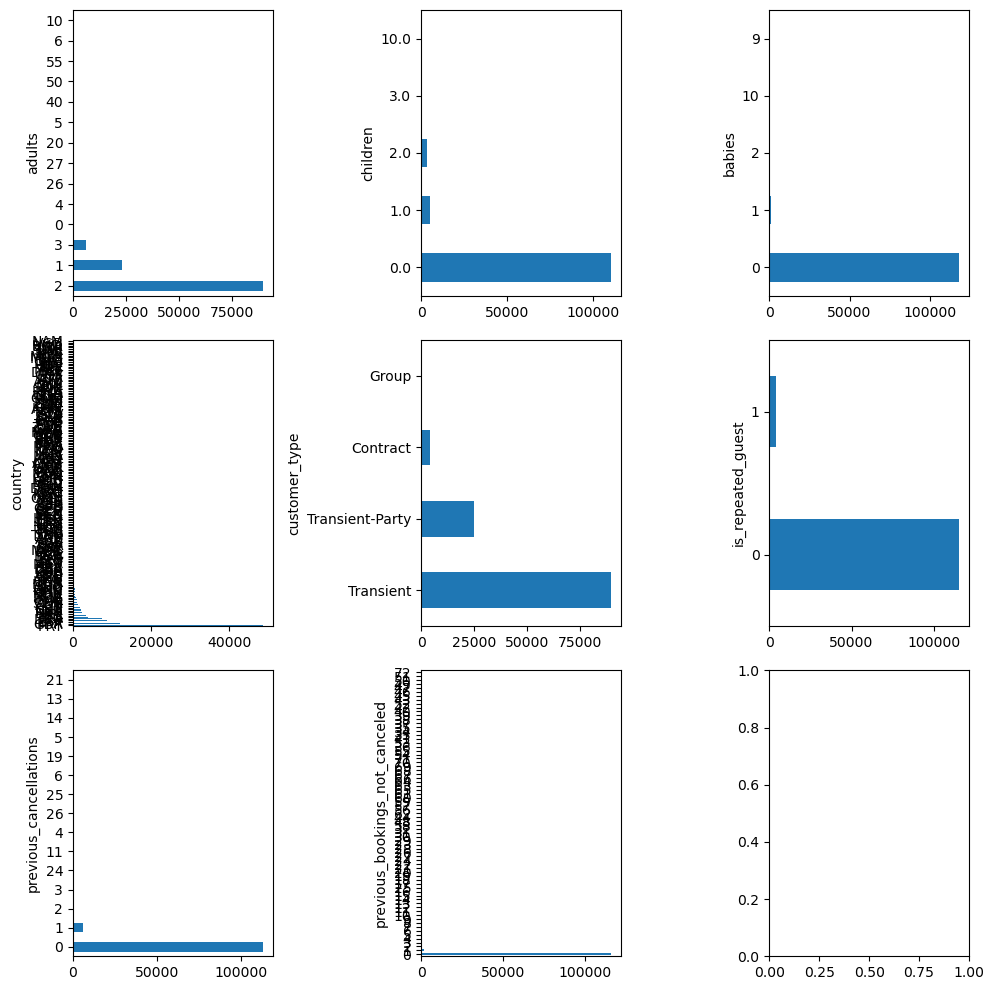

In [23]:
#Creating a value_count plot for each Guest Detail Column

#Specify subplot dimensions
nrows=3
ncols=3

plt.subplots(nrows, ncols, figsize=(10,10))

for i, col in enumerate(init_clean_df[guest_detail_cols]):
    plt.subplot(nrows, ncols, i+1)
    init_clean_df[col].value_counts().plot(kind='barh')

plt.tight_layout()
plt.show()

Action Items for Guest Detail Columns:
1. Drop `country` column because there are too many columns to create dummy variables.
2. Binarize `children` and `babies` columns. Reservations are usually based on the number of `adults` in the room.

In [24]:
#Drop Country column
init_clean_df.drop(columns='country', inplace=True)
guest_detail_cols.remove('country')

In [25]:
#Binarize children and babies columns
init_clean_df['children'] = init_clean_df['children'].where(init_clean_df['children'] <=1 , 1)

init_clean_df['babies'] = init_clean_df['babies'].where(init_clean_df['babies'] <=1 , 1)

Identify clean version of the cleaned Guest Details Columns

In [26]:
#sanity check
init_clean_df[guest_detail_cols]

,adults,children,babies,customer_type,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled
0,2,0.0,0,Transient,0,0,0
1,2,0.0,0,Transient,0,0,0
2,1,0.0,0,Transient,0,0,0
3,1,0.0,0,Transient,0,0,0
4,2,0.0,0,Transient,0,0,0
...,...,...,...,...,...,...,...
119385,2,0.0,0,Transient,0,0,0
119386,3,0.0,0,Transient,0,0,0
119387,2,0.0,0,Transient,0,0,0
119388,2,0.0,0,Transient,0,0,0


***

### <a id='toc1_1_4_'></a>[Misc Reservation Columns](#toc0_)

#### <a id='toc1_1_4_1_'></a>[Cleaning](#toc0_)

In [27]:
#Visualize the miscellaneous reservation columns
init_clean_df[misc_res_cols]

,meal,required_car_parking_spaces,total_of_special_requests
0,BB,0,0
1,BB,0,0
2,BB,0,0
3,BB,0,0
4,BB,0,1
...,...,...,...
119385,BB,0,0
119386,BB,0,2
119387,BB,0,4
119388,BB,0,0


In [28]:
#checking for nulls
init_clean_df[misc_res_cols].isnull().sum().loc[lambda x: x>0]

Series([], dtype: int64)

In [29]:
#checking number of unique values
init_clean_df[misc_res_cols].nunique()

meal                           5
required_car_parking_spaces    5
total_of_special_requests      6
dtype: int64

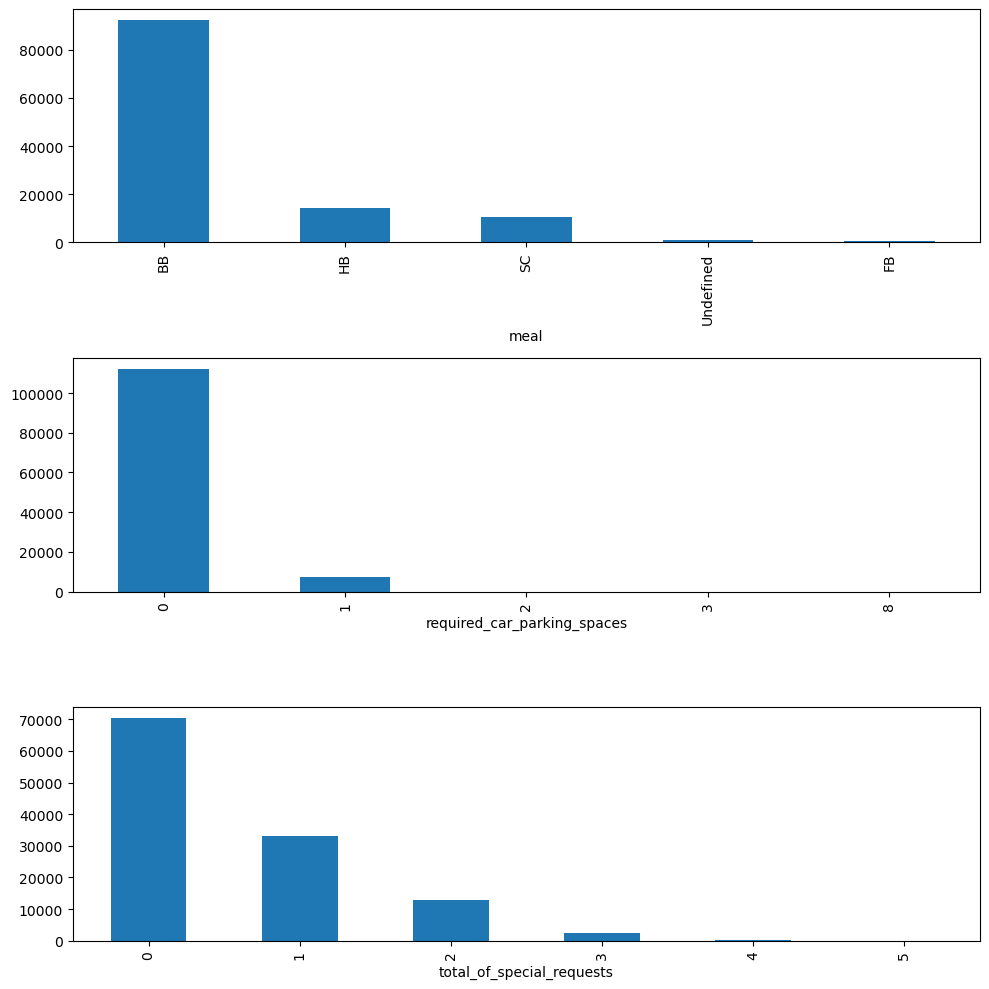

In [30]:
#Creating a value_count plot for each Misc Reservation Columns

#Specify subplot dimensions
nrows=3
ncols=1

plt.subplots(nrows, ncols, figsize=(10,10))

for i, col in enumerate(init_clean_df[misc_res_cols]):
    plt.subplot(nrows, ncols, i+1)
    init_clean_df[col].value_counts().plot(kind='bar')

plt.tight_layout()
plt.show()

The plot above doesnt look like parking spaces and meals are significant in the distribution. Might not be helpful for predicting demand or cancellations.  Potentially binarize or drop them.

In [31]:
init_clean_df['required_car_parking_spaces'].value_counts()

required_car_parking_spaces
0    111974
1      7383
2        28
3         3
8         2
Name: count, dtype: int64

Action Items for Misc Reservation Columns:
1. Binarize `required_car_parking_spaces` and `meal` for now instead of dropping to see if there is any correlation to our target variables.

In [32]:
#Binarize meal column
meal_mapping = {'BB': 1, 'HB': 1, 'SC': 1, 'FB' : 1, 'Undefined': 0}

init_clean_df['meal'] = init_clean_df['meal'].map(meal_mapping)

#Binarize required_car_parking_spaces
init_clean_df['required_car_parking_spaces'] = init_clean_df['required_car_parking_spaces'].fillna(0).clip(upper=1)

In [33]:
#Sanity Check
init_clean_df[misc_res_cols]

,meal,required_car_parking_spaces,total_of_special_requests
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,1
...,...,...,...
119385,1,0,0
119386,1,0,2
119387,1,0,4
119388,1,0,0


***

### <a id='toc1_1_5_'></a>[Room Reservation Columns](#toc0_)

#### <a id='toc1_1_5_1_'></a>[Cleaning](#toc0_)

In [34]:
#Visualize Room Reservation Columns
init_clean_df[room_res_cols]

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,adr,reservation_status,assigned_room_type
0,Resort Hotel,0,342,0,0,Direct,Direct,C,3,No Deposit,NaN,NaN,0,0.00,Check-Out,C
1,Resort Hotel,0,737,0,0,Direct,Direct,C,4,No Deposit,NaN,NaN,0,0.00,Check-Out,C
2,Resort Hotel,0,7,0,1,Direct,Direct,A,0,No Deposit,NaN,NaN,0,75.00,Check-Out,C
3,Resort Hotel,0,13,0,1,Corporate,Corporate,A,0,No Deposit,304.0,NaN,0,75.00,Check-Out,A
4,Resort Hotel,0,14,0,2,Online TA,TA/TO,A,0,No Deposit,240.0,NaN,0,98.00,Check-Out,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2,5,Offline TA/TO,TA/TO,A,0,No Deposit,394.0,NaN,0,96.14,Check-Out,A
119386,City Hotel,0,102,2,5,Online TA,TA/TO,E,0,No Deposit,9.0,NaN,0,225.43,Check-Out,E
119387,City Hotel,0,34,2,5,Online TA,TA/TO,D,0,No Deposit,9.0,NaN,0,157.71,Check-Out,D
119388,City Hotel,0,109,2,5,Online TA,TA/TO,A,0,No Deposit,89.0,NaN,0,104.40,Check-Out,A


In [35]:
#Checking null values
init_clean_df[room_res_cols].isnull().sum().loc[lambda x: x>0]

agent       16340
company    112593
dtype: int64

In [36]:
#Checking number of unique values
init_clean_df[room_res_cols].nunique()

hotel                         2
is_canceled                   2
lead_time                   479
stays_in_weekend_nights      17
stays_in_week_nights         35
market_segment                8
distribution_channel          5
reserved_room_type           10
booking_changes              21
deposit_type                  3
agent                       333
company                     352
days_in_waiting_list        128
adr                        8879
reservation_status            3
assigned_room_type           12
dtype: int64

In [37]:
init_clean_df[room_res_cols].describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,booking_changes,agent,company,days_in_waiting_list,adr
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000
mean,0.370416,104.011416,0.927599,2.500302,0.221124,86.693382,189.266735,2.321149,101.831122
std,0.482918,106.863097,0.998613,1.908286,0.652306,110.774548,131.655015,17.594721,50.535790
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000
25%,0.000000,18.000000,0.000000,1.000000,0.000000,9.000000,62.000000,0.000000,69.290000
50%,0.000000,69.000000,1.000000,2.000000,0.000000,14.000000,179.000000,0.000000,94.575000
75%,1.000000,160.000000,2.000000,3.000000,0.000000,229.000000,270.000000,0.000000,126.000000
max,1.000000,737.000000,19.000000,50.000000,21.000000,535.000000,543.000000,391.000000,5400.000000


Identified negative `adr` min value

In [38]:
#Checking value counts for all room reservation columns
for col in init_clean_df[room_res_cols]:
    print(f"Column: {col}")
    print(init_clean_df[col].value_counts())
    print("\n")

Column: hotel
hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64


Column: is_canceled
is_canceled
0    75166
1    44224
Name: count, dtype: int64


Column: lead_time
lead_time
0      6345
1      3460
2      2069
3      1816
4      1715
       ... 
400       1
370       1
532       1
371       1
463       1
Name: count, Length: 479, dtype: int64


Column: stays_in_weekend_nights
stays_in_weekend_nights
0     51998
2     33308
1     30626
4      1855
3      1259
6       153
5        79
8        60
7        19
9        11
10        7
12        5
13        3
16        3
14        2
18        1
19        1
Name: count, dtype: int64


Column: stays_in_week_nights
stays_in_week_nights
2     33684
1     30310
3     22258
5     11077
4      9563
0      7645
6      1499
10     1036
7      1029
8       656
9       231
15       85
11       56
19       44
12       42
20       41
14       35
13       27
16       16
21       15
22        7
25        6
18        6
30        5

Action Items for Room Reservation Columns:
1. Impute nulls with 0 and Binarize `agent` and `company`columns.
2. Drop `reserved_room_type` and `assigned_room_type` because they would create too many dummy variables if we kept them.
3. Replace `adr` negatives with 0. ADR cannot be negative. For each reservation sold, they are provided a rate. Comp rooms are $0 and also would not make it negative.

In [39]:
#1. Impute nulls to 0 and Binarize agent and company. Yes = 1, No = 0
init_clean_df['agent'] = init_clean_df['agent'].fillna(0).clip(
    upper=1) #convert any value above 1 to be 1

init_clean_df['company'] = init_clean_df['company'].fillna(0).clip(upper=1)

In [40]:
#Sanity Check for agent column
init_clean_df['agent'].value_counts()

agent
1.0    103050
0.0     16340
Name: count, dtype: int64

In [41]:
#2 drop reserved room type and assigned room types
init_clean_df.drop(columns=['reserved_room_type','assigned_room_type'], inplace=True)

#Remove columns from room reservation columns list
room_res_cols.remove('reserved_room_type')
room_res_cols.remove('assigned_room_type')

In [42]:
#imputing any negative ADR to 0
init_clean_df['adr'] = np.where(init_clean_df['adr'] <0 , 0, init_clean_df['adr'])

In [43]:
#sanity check, min is now 0 and not negative
init_clean_df['adr'].describe()

count    119390.000000
mean        101.831175
std          50.535679
min           0.000000
25%          69.290000
50%          94.575000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

In [44]:
#Sanity Check
init_clean_df[room_res_cols]

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,market_segment,distribution_channel,booking_changes,deposit_type,agent,company,days_in_waiting_list,adr,reservation_status
0,Resort Hotel,0,342,0,0,Direct,Direct,3,No Deposit,0.0,0.0,0,0.00,Check-Out
1,Resort Hotel,0,737,0,0,Direct,Direct,4,No Deposit,0.0,0.0,0,0.00,Check-Out
2,Resort Hotel,0,7,0,1,Direct,Direct,0,No Deposit,0.0,0.0,0,75.00,Check-Out
3,Resort Hotel,0,13,0,1,Corporate,Corporate,0,No Deposit,1.0,0.0,0,75.00,Check-Out
4,Resort Hotel,0,14,0,2,Online TA,TA/TO,0,No Deposit,1.0,0.0,0,98.00,Check-Out
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2,5,Offline TA/TO,TA/TO,0,No Deposit,1.0,0.0,0,96.14,Check-Out
119386,City Hotel,0,102,2,5,Online TA,TA/TO,0,No Deposit,1.0,0.0,0,225.43,Check-Out
119387,City Hotel,0,34,2,5,Online TA,TA/TO,0,No Deposit,1.0,0.0,0,157.71,Check-Out
119388,City Hotel,0,109,2,5,Online TA,TA/TO,0,No Deposit,1.0,0.0,0,104.40,Check-Out


In [45]:
#Dtype recheck
init_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_week_number        119390 non-null  int64         
 4   stays_in_weekend_nights         119390 non-null  int64         
 5   stays_in_week_nights            119390 non-null  int64         
 6   adults                          119390 non-null  int64         
 7   children                        119390 non-null  float64       
 8   babies                          119390 non-null  int64         
 9   meal                            119390 non-null  int64         
 10  market_segment                  119390 non-null  object 

In [46]:
#Convert children, agent, and company to INT data types
init_clean_df['children']= init_clean_df['children'].astype(int)

init_clean_df['agent']= init_clean_df['agent'].astype(int)

init_clean_df['company']= init_clean_df['company'].astype(int)

In [47]:
#sanity check
init_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_week_number        119390 non-null  int64         
 4   stays_in_weekend_nights         119390 non-null  int64         
 5   stays_in_week_nights            119390 non-null  int64         
 6   adults                          119390 non-null  int64         
 7   children                        119390 non-null  int64         
 8   babies                          119390 non-null  int64         
 9   meal                            119390 non-null  int64         
 10  market_segment                  119390 non-null  object 

In [48]:
#Create cleaned hotel dataframe for EDA
hotel_clean_df = init_clean_df.copy()
hotel_clean_df.head()

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,27,0,0,2,0,0,1,Direct,Direct,0,0,0,3,No Deposit,0,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,27,0,0,2,0,0,1,Direct,Direct,0,0,0,4,No Deposit,0,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,27,0,1,1,0,0,1,Direct,Direct,0,0,0,0,No Deposit,0,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,27,0,1,1,0,0,1,Corporate,Corporate,0,0,0,0,No Deposit,1,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,27,0,2,2,0,0,1,Online TA,TA/TO,0,0,0,0,No Deposit,1,0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01


In [49]:
#Creating missing target variable

#value counts of arrival_date
day_demand_counts = hotel_clean_df['arrival_date'].value_counts()

#Creating day_demand target variable
hotel_clean_df['day_demand'] = hotel_clean_df['arrival_date'].map(day_demand_counts)
hotel_clean_df['day_demand']

0         122
1         122
2         122
3         122
4         122
         ... 
119385     89
119386    134
119387    134
119388    134
119389    125
Name: day_demand, Length: 119390, dtype: int64

In [50]:
hotel_clean_df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_week_number          0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
reservation_status_date           0
arrival_date                      0
day_demand                  

***

## <a id='toc1_2_'></a>[EDA](#toc0_)

### <a id='toc1_2_1_'></a>[City Hotel vs. Resort Hotel](#toc0_)

In [51]:
#Create 2 variables to compare City Hotel vs Resort Hotel
city_hotel = hotel_clean_df[hotel_clean_df['hotel']=='City Hotel']
resort_hotel = hotel_clean_df[hotel_clean_df['hotel']=='Resort Hotel']

In [52]:
city_rows = city_hotel.shape[0]
resort_rows = resort_hotel.shape[0]

print(f' The City Hotel has {city_rows} reservations in this dataset.')
print(f' The Resort Hotel has {resort_rows} reservations in this dataset.')

 The City Hotel has 79330 reservations in this dataset.
 The Resort Hotel has 40060 reservations in this dataset.


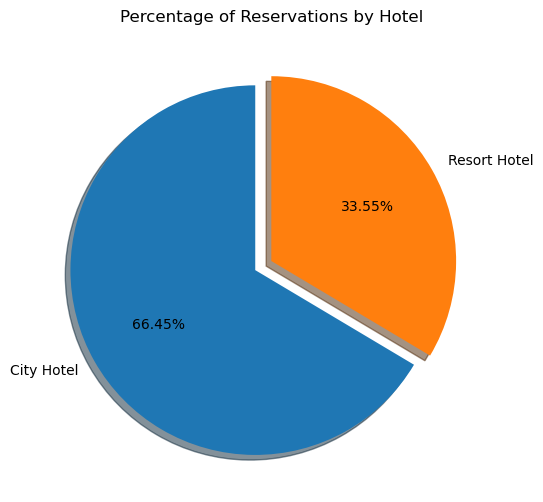

In [53]:
#Plot pie plot of total reservations between city and resort hotels
hotel_labels = 'City Hotel', 'Resort Hotel'
hotel_sizes = [city_rows, resort_rows]
explode = (0.1,0)

fig, ax = plt.subplots()

ax.pie(hotel_sizes, 
       labels=hotel_labels,
       explode=explode,
       autopct='%1.2f%%', #show 2 percentage points
       shadow=True,
       startangle=90      
)
plt.title('Percentage of Reservations by Hotel')
plt.show()

Almost 67% of the reservations in this dataset are for the City Hotel.

### <a id='toc1_2_2_'></a>[Time series for demand over time](#toc0_)

In [54]:
#DF for plotting
demand_by_date = hotel_clean_df.groupby('arrival_date').size() #provides the count of elements by arrival_date

In [55]:
#Plotting demand over time
fig = px.line(demand_by_date, width=1000, height=500, title='Demand over time by Arrival Date')
fig.update_layout(showlegend=False, yaxis_title='Bookings', xaxis_title='Date')

Daily demand over time contains too much noise.  Need to resample to bring more clarity

In [56]:
#Resampling the plot to add clarity
demand_by_week = demand_by_date.resample('W').mean()

#Plotting demand over time

fig = px.line(demand_by_week, width=1000, height=500, title='Weekly Demand Over Time')
fig.update_layout(showlegend=False, yaxis_title='Bookings', xaxis_title='Date')

The line plot above shows some seasonality. The number of bookings reach a peak in the month of October and decline to a valley in January.  Bookings increase again in April.  There is only 2 years of data in this dataset, but this seems to be a start of a trend.

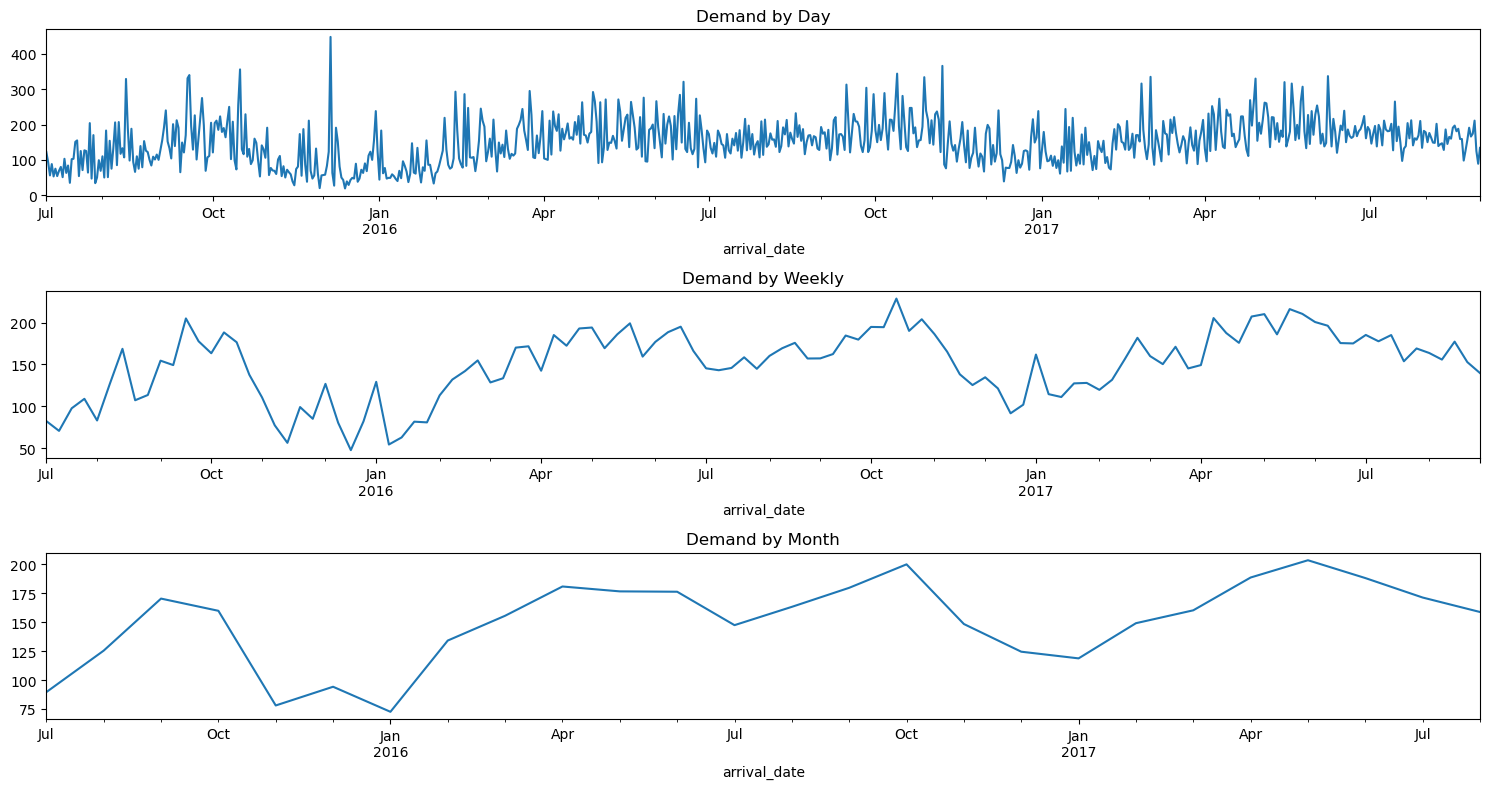

In [57]:
#Plot to compare reshaping options
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 8))

demand_by_date.plot(ax=ax[0], title='Demand by Day')
demand_by_date.resample('W').mean().plot(ax=ax[1], title='Demand by Weekly')
demand_by_date.resample('MS').mean().plot(ax=ax[2], title='Demand by Month')

plt.tight_layout()

plt.show()

Plot above show that Demandy by week gives a good balance between reducing noise but still providing the peaks and valleys I'm looking for.

### <a id='toc1_2_3_'></a>[Time series for Cancellation over time](#toc0_)

In [58]:
hotel_clean_df[['arrival_date','is_canceled']]

,arrival_date,is_canceled
0,2015-07-01,0
1,2015-07-01,0
2,2015-07-01,0
3,2015-07-01,0
4,2015-07-01,0
...,...,...
119385,2017-08-30,0
119386,2017-08-31,0
119387,2017-08-31,0
119388,2017-08-31,0


In [59]:
# Group the data by 'arrival_date' and sum up the 'is_canceled' values
cancellations_per_date = hotel_clean_df.groupby('arrival_date')['is_canceled'].sum().reset_index()

# Display the resulting DataFrame
print(cancellations_per_date)

    arrival_date  is_canceled
0     2015-07-01           19
1     2015-07-02           57
2     2015-07-03           19
3     2015-07-04           43
4     2015-07-05           16
..           ...          ...
788   2017-08-27           49
789   2017-08-28           64
790   2017-08-29           44
791   2017-08-30           27
792   2017-08-31           45

[793 rows x 2 columns]


In [60]:
cancellations_per_date.set_index('arrival_date',inplace=True)

In [61]:
cancellations_per_date.head()

,is_canceled
arrival_date,
2015-07-01,19
2015-07-02,57
2015-07-03,19
2015-07-04,43
2015-07-05,16


In [62]:
#Plotting demand over time
fig = px.line(cancellations_per_date, width=1000, height=500, title='Cancellations over time by Arrival Date')
fig.update_layout(showlegend=False, yaxis_title='Cancellations', xaxis_title='Date')

Similar to the demand plot, this cancellation by day has too much noise. Need to resample.

In [63]:
#Resampling the plot to add clarity
cxl_by_week = cancellations_per_date.resample('W').mean()

#Plotting cancellations over time

fig = px.line(cxl_by_week, width=1000, height=500, title='Weekly Cancellations Over Time')
fig.update_layout(showlegend=False, yaxis_title='Cancellations', xaxis_title='Date')

The trends for weekly cancellations seem similar to that of demand. Peaks in October, Valley in January, and peaks again in April.  This seems like a trend.  Also as more demand is available, it is safe to assume cancellations might also increase/follow the same pattern.

### <a id='toc1_2_4_'></a>[CXL percentages over time](#toc0_)

Next I want to explore what percentage of the reservations were cancelled. A percentage value may help me understand these cancellations clearer. In order to do so, I need to combine my cancellations and demand data together into one dataframe.

In [64]:
#Checking the data type of cancellations per date
type(cancellations_per_date)

pandas.core.frame.DataFrame

In [65]:
#converting demand per date series into a dataframe
demand_per_date_df = pd.DataFrame(demand_by_date)

In [66]:
#rename column demand
demand_per_date_df.columns = ['demand']

In [67]:
#sanity check of demand per date dataframe
demand_per_date_df

,demand
arrival_date,
2015-07-01,122
2015-07-02,93
2015-07-03,56
2015-07-04,88
2015-07-05,53
...,...
2017-08-27,174
2017-08-28,211
2017-08-29,125


In [68]:
#Merging dataframes together
cxl_pct_df = pd.merge(cancellations_per_date, demand_per_date_df, on='arrival_date')

In [69]:
#calculating cancellation percentage
cxl_pct_df['cancellation percent'] = cxl_pct_df['is_canceled']/cxl_pct_df['demand']*100

In [70]:
#sanity check
cxl_pct_df.head(5)

,is_canceled,demand,cancellation percent
arrival_date,,,
2015-07-01,19,122,15.573770
2015-07-02,57,93,61.290323
2015-07-03,19,56,33.928571
2015-07-04,43,88,48.863636
2015-07-05,16,53,30.188679


In [71]:
#Resampling to week assuming the noise will be the same if I plotted with the day level
cxl_pct = cxl_pct_df.resample('W').mean()

In [72]:
#dropping is cancelled and demand columns now that I have cancellation percentage
cxl_pct.drop(columns='is_canceled', inplace=True)
cxl_pct.drop(columns='demand', inplace=True)

In [73]:
#Plotting cancellation percentage over time
fig = px.line(cxl_pct, width=1000, height=500, title='Weekly Cancellation Percentages Over Time')
fig.update_layout(showlegend=True, yaxis_title='Cancellation Percentage', xaxis_title='Date')

The weekly cancellation percentages seem very high. It is reaching ~50% at the start of the data set and stays roughly between 30-40% cancellation % throughout the dataset.  

Next I want to look at cancellations between the city hotel and resort hotel over time to see if potentially one hotel is the cause for these high cancellation percentages.

In [74]:
# view cancellations for city hotel
city_cxl = city_hotel.groupby('arrival_date')['is_canceled'].sum().reset_index()

#set the arrival date as the index
city_cxl.set_index('arrival_date',inplace=True)

# Display the resulting DataFrame
print(city_cxl)

              is_canceled
arrival_date             
2015-07-01             14
2015-07-02             48
2015-07-03              6
2015-07-04             29
2015-07-05              8
...                   ...
2017-08-27             28
2017-08-28             27
2017-08-29             30
2017-08-30             13
2017-08-31             31

[793 rows x 1 columns]


In [75]:
# view cancellations for city hotel
resort_cxl = resort_hotel.groupby('arrival_date')['is_canceled'].sum().reset_index()

#set the arrival date as the index
resort_cxl.set_index('arrival_date',inplace=True)

# Display the resulting DataFrame
print(resort_cxl)

              is_canceled
arrival_date             
2015-07-01              5
2015-07-02              9
2015-07-03             13
2015-07-04             14
2015-07-05              8
...                   ...
2017-08-27             21
2017-08-28             37
2017-08-29             14
2017-08-30             14
2017-08-31             14

[793 rows x 1 columns]


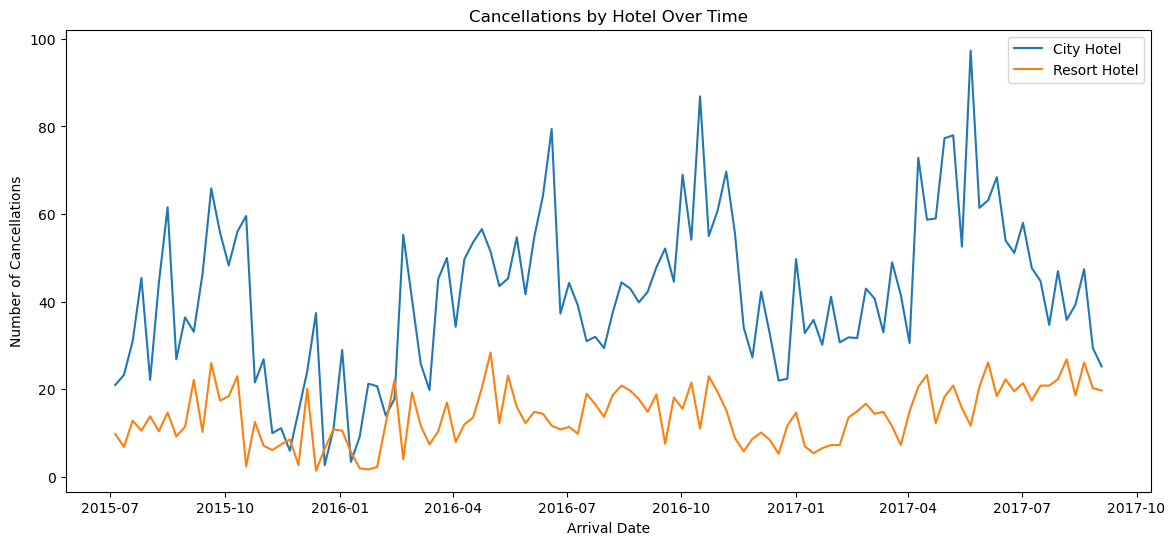

In [76]:
#Resampling the plot to show by week for more clarity
city_week_cxl = city_cxl.resample('W').mean()
resort_week_cxl = resort_cxl.resample('W').mean()

plt.figure(figsize=(14, 6))

# Plot the city hotel cancellations
plt.plot(city_week_cxl.index, city_week_cxl['is_canceled'], label='City Hotel')

# Plot the resort hotel cancellations
plt.plot(resort_week_cxl.index, resort_week_cxl['is_canceled'], label='Resort Hotel')

# Add labels and title
plt.xlabel('Arrival Date')
plt.ylabel('Number of Cancellations')
plt.title('Cancellations by Hotel Over Time')

# Add a legend
plt.legend()

# Display the plot
plt.show()



The cancellations for the city hotel has higher flucuations compared to the resort hotel.  This is reasonable to see as city hotels tend to have higher volume corporate travelers, who have more last minute bookings + cancellations due to last minute travel needs.

Resort hotels have more leisure guests which indicate that they may not cancel as easily due to the amount of planning that usually goes on for this type of traveler and it would take more for the traveler to cancel their plans compared to a corporate traveler in the city on business.

### <a id='toc1_2_5_'></a>[Compare Demand between the two hotels:](#toc0_)

Next I want to see the same comparison, but looking at demand between the city and resort hotel.

In [77]:
resort_hotel.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'day_demand'],
      dtype='object')

In [78]:
#Create dataframes for city and resort hotel demand
city_dem = city_hotel.groupby('arrival_date').size()
resort_dem = resort_hotel.groupby('arrival_date').size()

#resample by week
city_week_dem = city_dem.resample('W').mean()
resort_week_dem = resort_dem.resample('W').mean()

In [79]:
fig = go.Figure()

# Add the first line from city_week_dem
fig.add_trace(go.Scatter(x=city_week_dem.index, y=city_week_dem.values,
                         mode='lines', name='City Demand'))

# Add the second line from resort_week_dem
fig.add_trace(go.Scatter(x=resort_week_dem.index, y=resort_week_dem.values,
                         mode='lines', name='Resort Demand'))

# Customize layout
fig.update_layout(
    title='Demand by Hotel Over Time',
    width=1000,
    height=500,
    xaxis_title='Date',
    yaxis_title='Demand',
    showlegend=True
)

# Show the figure
fig.show()


The city hotel clearly shows higher demand and cancellations compared to the resort hotel.  There is also a similar trend/seasonality in peaks and valleys with the city hotel that resemble my earlier plot when looking at the overall combined demand between both hotels. This leads me to believe that the city hotel is more heavily influencing these trends.

## <a id='toc1_3_'></a>[Ideas for Next Steps](#toc0_)
Now that I have a high level overview of demand and cancellations throughout the data, how each hotel in the data set compares, and the overall cancellation percentages, there are a few next steps for further exploration:
1. How does demand look by `customer_type`, are groups contributing to an increase in cancellations?
2. Do certain `market_segments` or `distribution_channels` have an increase in demand or cancellations vs. the others?
3. What are the hotels booking windows? (`lead_time` vs. `arrival_date`)
4. How many days before arrival do they cancel? (`Reservation_status_date` vs `is_canceled`)
5. Explore feature engineering:
    - Total Hotel Capacity
    - Rooms On the Books
    - Occupancy
    - Length of Stay
    - Remaining Supply
    - Rooms Pick Up (1, 3, 5, 7+ days)
    - Booking Pace (variance of rooms OTB and pickup)

### <a id='toc1_3_1_'></a>[Cancellation Percentage over time by hotel](#toc0_)

### <a id='toc1_3_2_'></a>[Dummy Variables](#toc0_)

#### <a id='toc1_3_2_1_'></a>[Dummy Variables for Guest Detail Columns:](#toc0_)
1. Create dummy variables for `customer_type` 
2. Drop `Group` as the reference column

In [80]:
#Create dummy variables for guest detail columns
#guest_dummy_df = pd.get_dummies(init_clean_df[guest_detail_cols])
#guest_dummy_df

In [81]:
#Drop reference column customer type Group
#guest_dummy_df.drop(columns='customer_type_Group', inplace=True)

In [82]:
#Print guest dummy df
#guest_dummy_df.head()

#### <a id='toc1_3_2_2_'></a>[Dummy variables for Room Reservation Columns](#toc0_)

Create dummy variables for `hotel`, `market_segment`, `distribution_channel`, `deposit_type`, `reservation_status`

In [83]:
#Create dummy variables for market
#room_res_dummy_df = pd.get_dummies(init_clean_df[room_res_cols])

In [84]:
#Drop Reference columns for new dummy variables
#reference_cols = ['market_segment_Aviation','distribution_channel_GDS','deposit_type_Refundable','reservation_status_No-Show']

#room_res_dummy_df.drop(columns=reference_cols, inplace=True)

In [85]:
#room_res_dummy_df

In [86]:
#hotel_clean_df = pd.concat([room_res_dummy_df, guest_dummy_df, init_clean_df[time_dependent_cols],init_clean_df[misc_res_cols]],axis=1)
#hotel_clean_df

#### <a id='toc1_3_2_3_'></a>[Combine dummy variables with the cleaned version](#toc0_)
- init_clean_df[time_dependent_cols]
- guest_dummy_df
- init_clean_df[misc_res_cols]
- room_res_dummy_df

### <a id='toc1_3_3_'></a>[Splitting up the DF into a city/resort dataframe:](#toc0_)

In [87]:
#Create city hotel df
#city_hotel_df = hotel_clean_df[hotel_clean_df['hotel_City Hotel']== True]

#Create resort hotel df
#resort_hotel_df = hotel_clean_df[hotel_clean_df['hotel_Resort Hotel']== True]